In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import random
import seaborn as sns
import itertools as it
import pulp
import time


sys.path.append(os.path.join(os.getcwd(), 'code'))
from spatial_generation import Spatial, GroupSpatial
from elections import SNTV,Bloc,STV,Borda, ChamberlinCourant, Monroe, GreedyCC, PluralityVeto, SMRD, OMRD, DMRD, ExpandingApprovals
from tools import cost, costs, best_group_cost, remove_candidates, borda_matrix, group_representation, max_group_representation, qmin_cost
from election_sampling import election_sample, samples

%load_ext autoreload
%autoreload 2

In [2]:
# Colors for plotting!
#pal = sns.color_palette("hls", 8)
#tab20_colors = plt.cm.tab20b.colors
colors = ["#0099cd","#ffca5d","#00cd99","#99cd00","#cd0099","#9900cd","#8dd3c7",
        "#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5","#bc80bd",
        "#ccebc5","#ffed6f","#ffffb3","#a6cee3","#1f78b4","#b2df8a","#33a02c",
        "#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a","#b15928",
        "#64ffda","#00B8D4","#A1887F","#76FF03","#DCE775","#B388FF","#FF80AB",
        "#D81B60","#26A69A","#FFEA00","#6200EA",
    ]

colors2 = colors = colors[:6] + colors[-12::2]

# Group Representation

This notebook is designed to give some insight into how we ran our experiments and generated figures for them. The code for more computationally intensive experiments can be found in `experiments/` or computed with the code from `election_sampling.py`

In [3]:
# Choose number of voters n and the number of candidates m
n = 100
m = 20

# Choose the number of winners for the election
k = 4

### 2 Bloc Spatial Generation:

First we can get a feel for how to randomly generate positions 
for voters and candidates in a metric space. For a setting with 
2 Blocs (groups) of voters, we can define 2 voter distributions (in this case both 
normal) and 1 candidate distribution (in this case uniform).

In [5]:
# Means for each of the 2 Normal distributions
means = [[0, -2], [0, 2]]
stds = [0.5, 0.5]  # Standard deviations for each Normal distribution
two_party_G = [50,50]  # Group Sizes

# Create a list of voter parameters -- with each set of parameters being a dict
voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(two_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std
    
# define the single set of candidate paramters
candidate_params = {'low': -5, 'high': 5, 'size': 2}

# define a distance function between voters and candidates
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the group spatial generator object!
two_party_generator = GroupSpatial(m = m, g = len(two_party_G),
                    voter_dists = [np.random.normal]*len(two_party_G), voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [18]:
# Now each call .generate() will make a profile with random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = two_party_generator.generate(two_party_G)

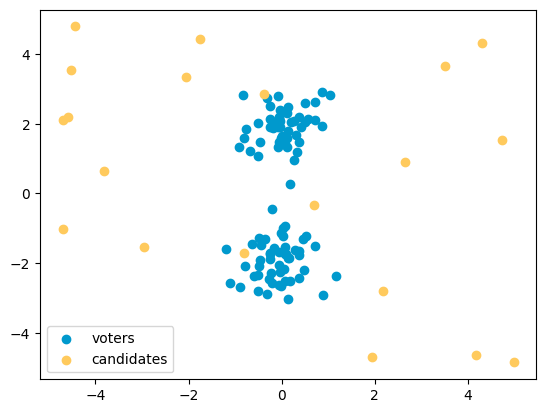

In [20]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
plt.legend()

### 4 Bloc Spatial Generation

And then you can mess around with the voter groups and distributions! Here I change it so that we have 4 normally distributed groups of voters:

In [8]:
# Means for each of the 4 Normal distributions
means = [[-2, 0], [2, 0], [0, 2], [0, -2]]
stds = [0.5, 0.5, 0.5, 0.5]  # Standard deviations for each Normal
four_party_G = [25, 25, 25, 25]  # Group Sizes

# Create a list of voter parameters -- with each set of parameters being a dict
voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(four_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std
    
# define the single set of candidate paramters
candidate_params = {'low': -3, 'high': 3, 'size': 2}

# define a distance function between voters and candidates
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the group spatial generator object!
four_party_generator = GroupSpatial(m = m, g = len(four_party_G),
                    voter_dists = [np.random.normal]*len(four_party_G), voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [21]:
# Now each call .generate() will make a profile with random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = four_party_generator.generate(four_party_G)

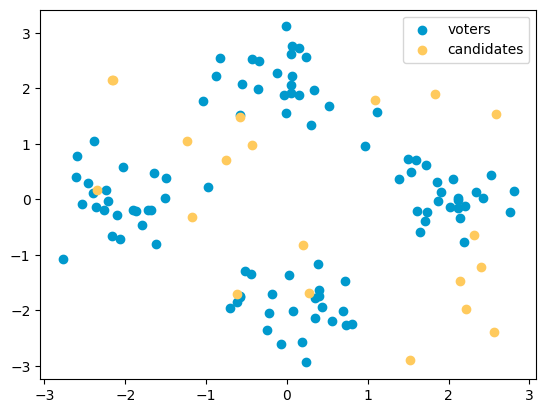

In [22]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
plt.legend()

Importantly, each call to `.generate()` will return a ranked preference profile, `profile`, an $n \times d$ array of voter positions, an $n \times m$ array of candidate positions, and a length $n$ array of labels describing each voter's group assignment.

In [23]:
# Here you can see the preference profile. Each column j represents a single voter j's ranking of candidates. 
# Each row i of a column j tells you which candidate voter j ranks at the ith position. 
profile

array([[13, 13, 13, ...,  1,  4,  4],
       [16,  0, 16, ...,  2,  1,  1],
       [ 4, 16,  0, ...,  4,  9,  9],
       ...,
       [ 6, 19, 19, ...,  6, 17,  5],
       [12,  2,  5, ..., 17,  6, 17],
       [ 5, 12, 12, ..., 18,  5, 18]], dtype=int64)

Importantly, I'm always using the convention that voters and candidates are labeled as integers [0,...,n-1] or [0,...,m-1]. The idea is that to be efficient we really only need pointers to the voter and candidate position arrays (instead of well named voters and candidates). For example, if `profile[i,j] = 10` then this tells me that the voter positioned at  `voter_position[j,:]` ranks the candidate positioned at `candidate_positions[10,:]` as being their `i`th favorite candidate.  

### Elections

Now, with our random spatial generators we'd like to be able to collect a bunch of samples where we 
1. Randomly generate voter and candidate positions
2. Run a set of election mechanisms on the ranked preference profile from that randomly generated setting
3. Record the results

Most of the heavy lifting for this process is done with `election_sampling.py`, but we show examples 
for how to interface with that here. 

NOTE: For deterministic results, set the seed with `np.random.seed(...)` (we use 918717)

In [4]:
# Define a dictionary of elections with input parameters given 
# (really only need it for DMRD but its implemented this way for completeness) :)
elections_dict = {SNTV:{}, Bloc:{}, STV:{},
                 Borda:{}, ChamberlinCourant:{}, GreedyCC:{}, Monroe:{}, PluralityVeto:{},
                 SMRD:{}, OMRD:{}, DMRD:{'rho': 0.5}, ExpandingApprovals: {}}

# List of elections being used
elections_list = [SNTV, Bloc, STV, Borda, ChamberlinCourant, GreedyCC, Monroe, 
                  PluralityVeto, ExpandingApprovals, SMRD, OMRD, DMRD]

# Number of samples to compute with
n_samples = 10000

In [24]:
# This shows you how to compute the sampled results and save to memory, 
# since this is a computationally intensive process, we omit running this for now
'''
# Compute election results and save to memory!
np.random.seed(918717)
f = 'data/2bloc.npz'
results_list = samples(n_samples, two_party_generator, elections_dict, [two_party_G], k, dim = 2, filename = f)
result_dict = results_list[0]
'''

"\n# Compute election results and save to memory!\nnp.random.seed(918717)\nf = 'data/2bloc.npz'\nresults_list = samples(n_samples, two_party_generator, elections_dict, [two_party_G], k, dim = 2, filename = f)\nresult_dict = results_list[0]\n"

In [5]:
# Or load in a set of precomputed results:
# NOTE: There are many examples from our paper which haven't been uploaded 
#       to the repository for space constraints. All files necessary for computing 
#       these datasets are included in the experiments/ folder. 

f = 'data/2bloc.npz'
loaded_data = np.load(f)
result_dict = {key: loaded_data[key] for key in loaded_data.files}

In [9]:
result_dict['SNTV']

array([[ 0.15908564, -1.51916198],
       [ 0.63037776,  1.59909622],
       [ 0.20782575,  3.9687421 ],
       [-1.85260256, -4.03726945]])

In [11]:
result_dict.keys()

dict_keys(['SNTV', 'Bloc', 'STV', 'Borda', 'ChamberlinCourant', 'GreedyCC', 'Monroe', 'PluralityVeto', 'ExpandingApprovals', 'SMRD', 'OMRD', 'DMRD', 'voters', 'candidates', 'labels'])

In [ ]:
result_dict

In [66]:
V = result_dict['voters'][0]
C = result_dict['candidates'][0]

In [69]:
costs(V,C)

array([486.87482023, 477.20278742, 214.92568232, 507.03142994,
       422.54967449, 218.24666963, 650.9969973 , 406.30698752,
       416.43877279, 296.0771877 , 450.27529327, 554.60551335,
       482.45204561, 406.2449412 , 567.09845216, 371.78697133,
       391.83801129, 227.02150397, 470.53851249, 286.26295013])

In [72]:
(V[np.newaxis, :, :] - C[:, np.newaxis, :]).shape

(20, 100, 2)

### Distribution Plot

Now we can see what the distribution of results looks like for each election mechanism. 
For each we show a Kernel Density Estimate (KDE) for the distribution of voter and winner positions. 
We also show scatter plots for the aggregation of all voter and candidate positions seen throughout the 
samples, as well as for a single election example.

NOTE: The KDE's will look a bit strange when you plot them here. That's because we're only using a small fraction of the collected samples to compute the KDE in this notebook. You can produce the full KDE with the code in `experiments/`.

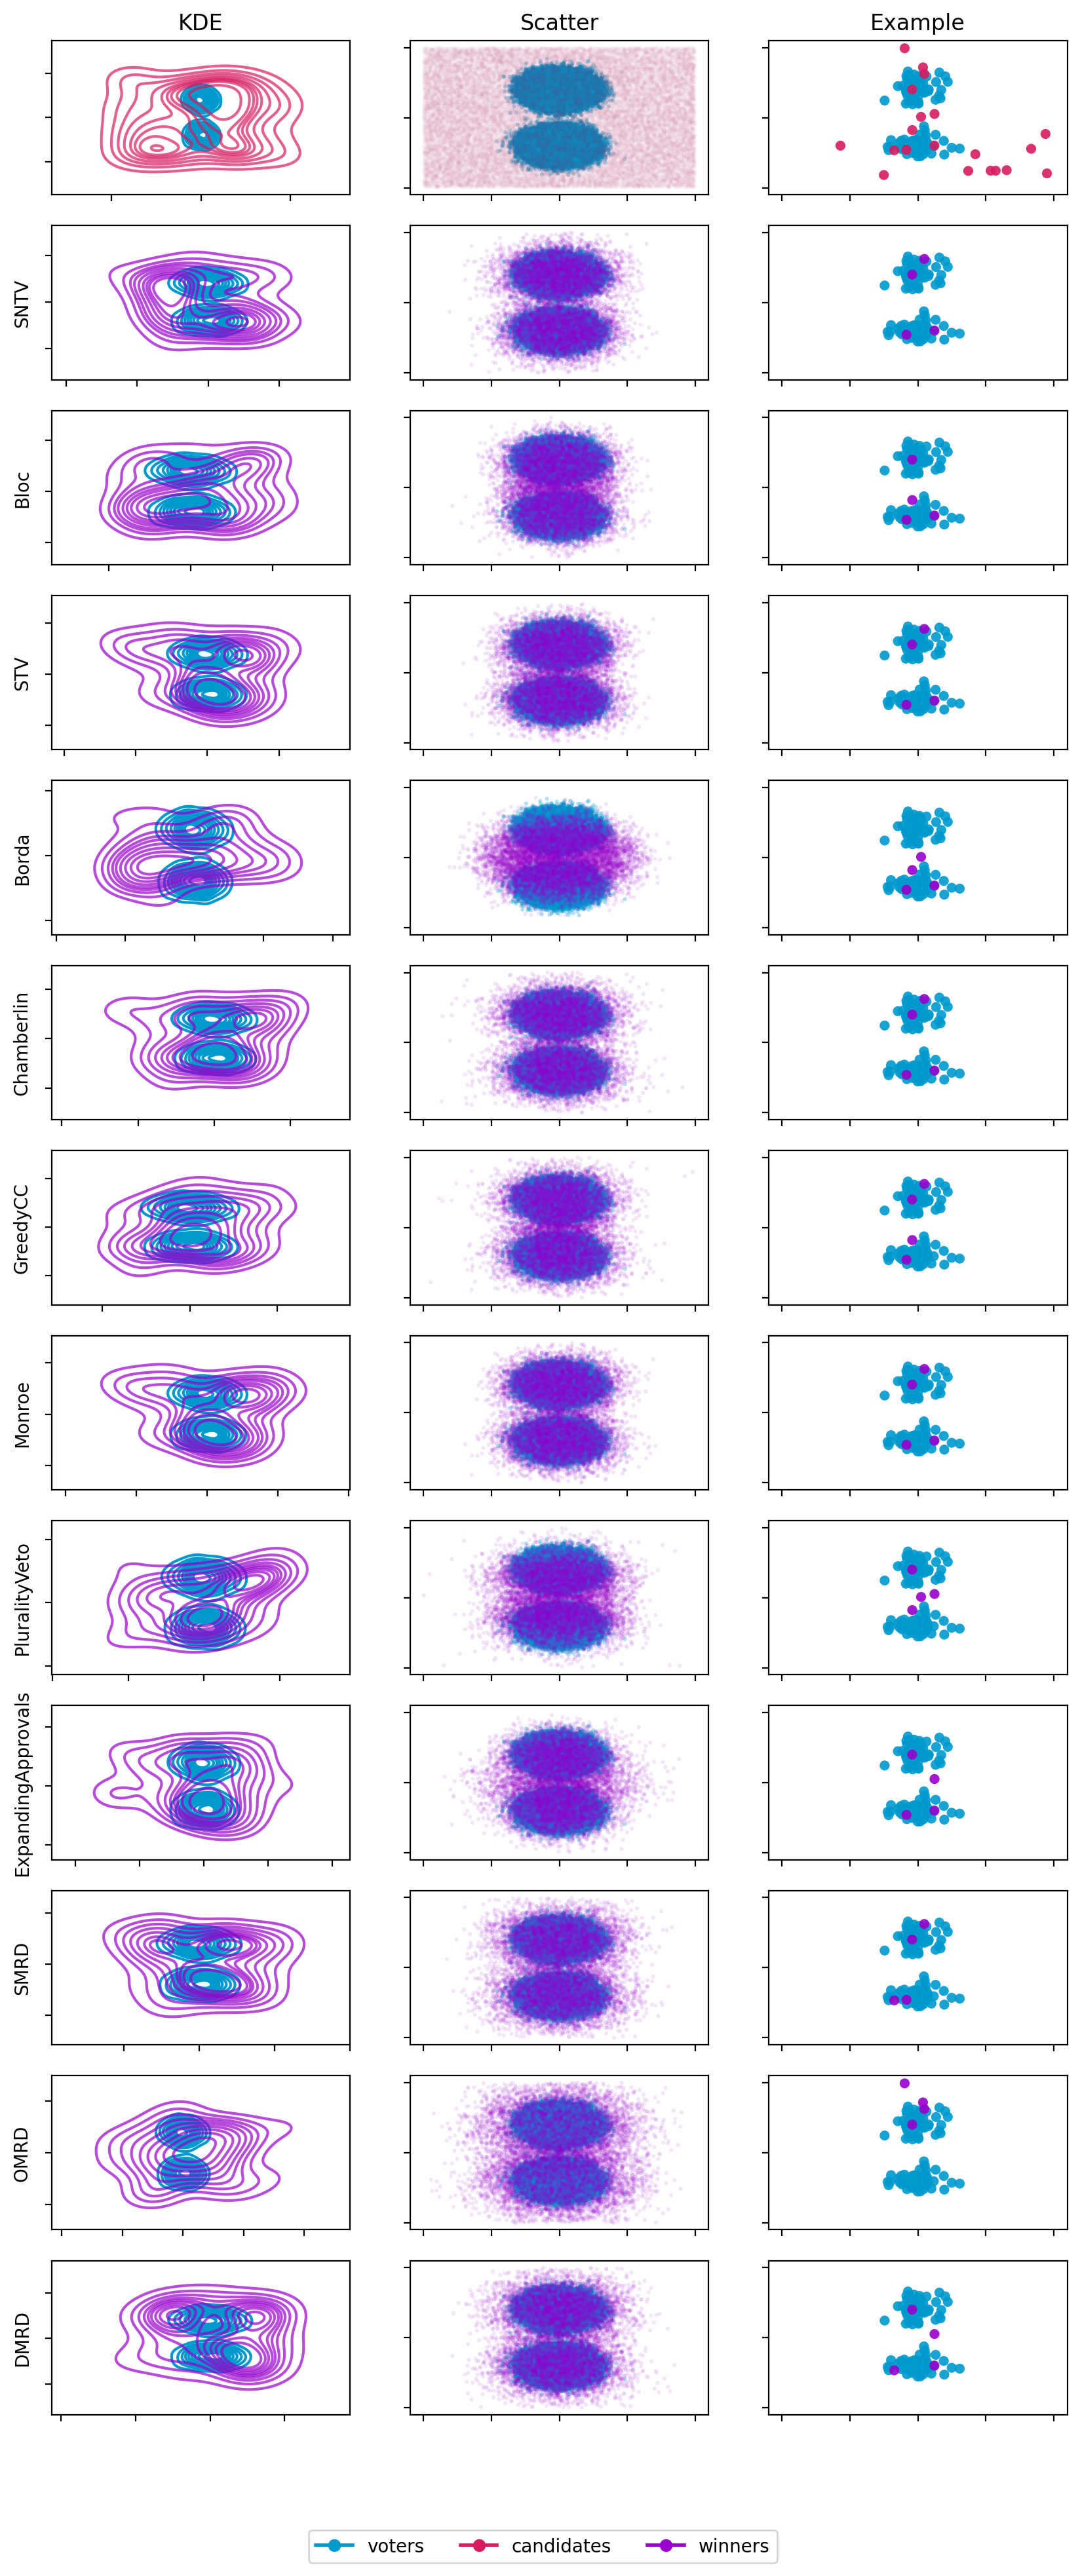

In [10]:
fig, axes = plt.subplots(len(elections_list) + 1, 3, figsize=(10, 24), dpi = 200)

for i, ax in enumerate(axes.flat):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

vc = colors[0]
cc = colors[-4]
wc = colors[5]

# Index for the sample used for the example plots:
sample_idx = 1
voter_example = result_dict['voters'][sample_idx]
voter_stack = pd.DataFrame(np.vstack(result_dict['voters']), columns = ['x','y'])
# Use a smaller sample for KDE plots (otherwise takes a while to run! -- You can run this fully with the scripts in experiments/)
voter_stack_sample1 = voter_stack.sample(frac=0.001, random_state=42)
voter_stack_sample2 = voter_stack.sample(frac=0.25, random_state=42)

# Just showing the distribution without the election
candidate_example = result_dict['candidates'][sample_idx]
candidate_stack = pd.DataFrame(np.vstack(result_dict['candidates']), columns = ['x','y'])
# Use a smaller sample for KDE plots  (otherwise takes a while to run! -- You can run this fully with the scripts in experiments/)
candidate_stack_sample1 = candidate_stack.sample(frac=0.001, random_state=42)
candidate_stack_sample2 = candidate_stack.sample(frac=0.25, random_state=42)

# Set x and y limits for scatter and example plots:
epsilon = 0.5
scatter_xlim = [-5 - epsilon,5 + epsilon]
scatter_ylim = [-5 - epsilon,5 + epsilon]

example_xlim = [-5 - epsilon,5 + epsilon]
example_ylim = [-5 - epsilon,5 + epsilon]


sns.kdeplot(data=voter_stack_sample1, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, alpha = 1, ax = axes[0][0])
sns.kdeplot(data=candidate_stack_sample1, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.7, ax = axes[0][0])
axes[0][0].set_title('KDE')
axes[0][0].set_ylabel('')
axes[0][0].set_xlabel('')


axes[0][1].scatter(voter_stack_sample2.iloc[:,0], voter_stack_sample2.iloc[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.3, s = 5)
axes[0][1].scatter(candidate_stack_sample2.iloc[:,0], candidate_stack_sample2.iloc[:,1],
                   facecolors = cc, edgecolors = 'none', alpha = 0.01, s = 5)
axes[0][1].set_xlim(scatter_xlim)
axes[0][1].set_ylim(scatter_ylim)
axes[0][1].set_title('Scatter')


axes[0][2].scatter(voter_example[:,0], voter_example[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.9, s = 30)
axes[0][2].scatter(candidate_example[:,0], candidate_example[:,1],
                   facecolors = cc, edgecolors = 'none', alpha = 0.9, s = 30)
axes[0][2].set_xlim(example_xlim)
axes[0][2].set_ylim(example_ylim)
axes[0][2].set_title('Example')


for i,E in enumerate(elections_list):
    name = E.__name__
    name_label = name
    if name == 'ChamberlinCourant':
        name_label = 'Chamberlin'
        
    ax_idx = i + 1

    winner_example = result_dict[name][sample_idx]
    winner_stack = pd.DataFrame(np.vstack(result_dict[name]), columns = ['x','y'])
    
    # Use a smaller sample for KDE plots  (otherwise takes a while to run! -- You can run this fully with the scripts in experiments/)
    winner_stack_sample1 = winner_stack.sample(frac=0.001, random_state=42)
    winner_stack_sample2 = winner_stack.sample(frac=0.25, random_state=42)
    
    sns.kdeplot(data=voter_stack_sample1, x='x', y='y', color = vc, fill=False,
                thresh=0.1, levels=10, alpha = 1, ax = axes[ax_idx][0])
    sns.kdeplot(data=winner_stack_sample1, x='x', y='y', color = wc, fill=False,
                thresh=0.1, levels=10, alpha = 0.7, ax = axes[ax_idx][0])
    axes[ax_idx][0].set_ylabel(name_label)
    axes[ax_idx][0].set_xlabel('')
    
    axes[ax_idx][1].scatter(voter_stack_sample2.iloc[:,0], voter_stack_sample2.iloc[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.3, s = 5)
    axes[ax_idx][1].scatter(winner_stack_sample2.iloc[:,0], winner_stack_sample2.iloc[:,1],
                       facecolors = wc, edgecolors = 'none', alpha = 0.1, s = 5)
    axes[ax_idx][1].set_xlim(scatter_xlim)
    axes[ax_idx][1].set_ylim(scatter_ylim)

    axes[ax_idx][2].scatter(voter_example[:,0], voter_example[:,1],
                       facecolors = vc, edgecolors = 'none', alpha = 0.9, s = 30)
    axes[ax_idx][2].scatter(winner_example[:,0], winner_example[:,1],
                       facecolors = wc, edgecolors = 'none', alpha = 0.9, s = 30)
    axes[ax_idx][2].set_xlim(example_xlim)
    axes[ax_idx][2].set_ylim(example_ylim)
     

legend_elements = [Line2D([0], [0], marker = 'o', color=vc, lw=2, label='voters'),
                   Line2D([0], [0], marker = 'o', color=cc, lw=2, label='candidates'),
                  Line2D([0], [0], marker = 'o', color=wc, lw=2, label='winners')]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.075), ncol=3)

### Least Satisfied Voter Blocs

In [34]:
def least_satisfied_bloc(V, W, size):
    # Should make this custom to fit any distance function!!
    n,d = V.shape
    k,d2 = W.shape
    proportional_share = int(k*size/n)
    
    voter_prop_distances = np.zeros(n)
    
    for idx, v in enumerate(V):
        dists = np.sort(np.linalg.norm(v - W, axis = 1))[:proportional_share]
        voter_prop_distances[idx] = np.sum(dists)
        
    
    least_satisfied_indices = np.argsort(voter_prop_distances)[::-1][:size]
    
    return V[least_satisfied_indices,:]

In [48]:
worst_bloc_dict = {}
bloc_size = 50

for i,E in enumerate(elections_list):
    name = E.__name__
    
    worst_samples = []
    for j in range(n_samples):
        Vp = result_dict['voters'][j]
        Wp = result_dict[name][j]
        V_worsts = least_satisfied_bloc(Vp, Wp, bloc_size)
        worst_samples.append(V_worsts)
        
    worst_bloc_dict[name] = np.array(worst_samples)

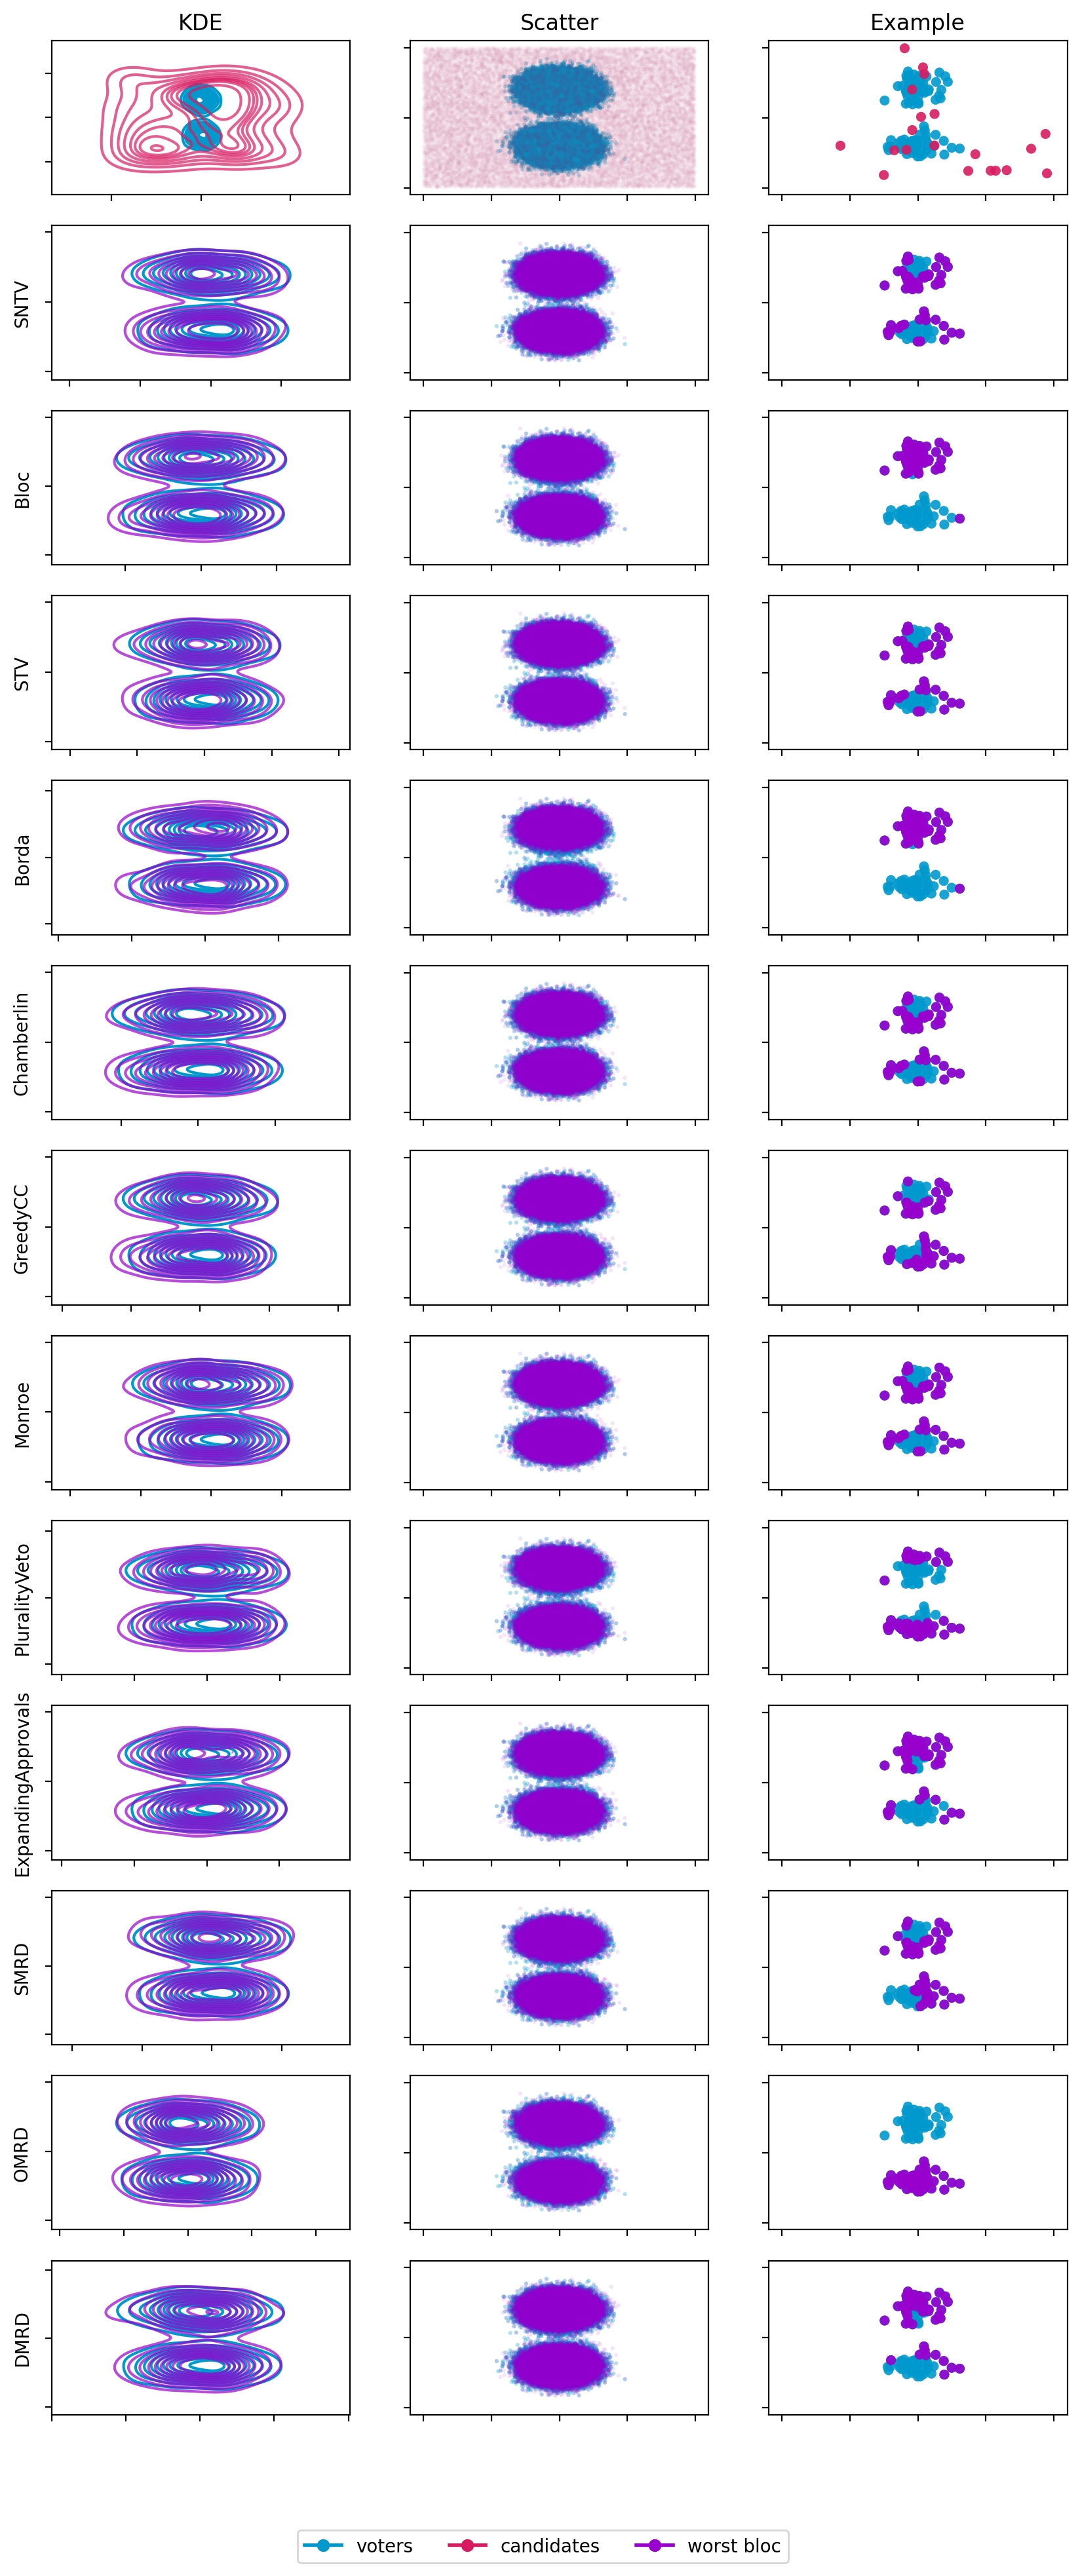

In [49]:
fig, axes = plt.subplots(len(elections_list) + 1, 3, figsize=(10, 24), dpi = 200)

for i, ax in enumerate(axes.flat):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

vc = colors[0]
cc = colors[-4]
wc = colors[5]

# Index for the sample used for the example plots:
sample_idx = 1
voter_example = result_dict['voters'][sample_idx]
voter_stack = pd.DataFrame(np.vstack(result_dict['voters']), columns = ['x','y'])
# Use a smaller sample for KDE plots (otherwise takes a while to run! -- You can run this fully with the scripts in experiments/)
voter_stack_sample1 = voter_stack.sample(frac=0.001, random_state=42)
voter_stack_sample2 = voter_stack.sample(frac=0.25, random_state=42)

# Just showing the distribution without the election
candidate_example = result_dict['candidates'][sample_idx]
candidate_stack = pd.DataFrame(np.vstack(result_dict['candidates']), columns = ['x','y'])
# Use a smaller sample for KDE plots  (otherwise takes a while to run! -- You can run this fully with the scripts in experiments/)
candidate_stack_sample1 = candidate_stack.sample(frac=0.001, random_state=42)
candidate_stack_sample2 = candidate_stack.sample(frac=0.25, random_state=42)

# Set x and y limits for scatter and example plots:
epsilon = 0.5
scatter_xlim = [-5 - epsilon,5 + epsilon]
scatter_ylim = [-5 - epsilon,5 + epsilon]

example_xlim = [-5 - epsilon,5 + epsilon]
example_ylim = [-5 - epsilon,5 + epsilon]


sns.kdeplot(data=voter_stack_sample1, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, alpha = 1, ax = axes[0][0])
sns.kdeplot(data=candidate_stack_sample1, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.7, ax = axes[0][0])
axes[0][0].set_title('KDE')
axes[0][0].set_ylabel('')
axes[0][0].set_xlabel('')


axes[0][1].scatter(voter_stack_sample2.iloc[:,0], voter_stack_sample2.iloc[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.3, s = 5)
axes[0][1].scatter(candidate_stack_sample2.iloc[:,0], candidate_stack_sample2.iloc[:,1],
                   facecolors = cc, edgecolors = 'none', alpha = 0.01, s = 5)
axes[0][1].set_xlim(scatter_xlim)
axes[0][1].set_ylim(scatter_ylim)
axes[0][1].set_title('Scatter')


axes[0][2].scatter(voter_example[:,0], voter_example[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.9, s = 30)
axes[0][2].scatter(candidate_example[:,0], candidate_example[:,1],
                   facecolors = cc, edgecolors = 'none', alpha = 0.9, s = 30)
axes[0][2].set_xlim(example_xlim)
axes[0][2].set_ylim(example_ylim)
axes[0][2].set_title('Example')


###################################################################################################

for i,E in enumerate(elections_list):
    name = E.__name__
    name_label = name
    if name == 'ChamberlinCourant':
        name_label = 'Chamberlin'
        
    ax_idx = i + 1

    worst_example = worst_bloc_dict[name][sample_idx]
    worst_stack = pd.DataFrame(np.vstack(worst_bloc_dict[name]), columns = ['x','y'])
    
    # Use a smaller sample for KDE plots  (otherwise takes a while to run! -- You can run this fully with the scripts in experiments/)
    worst_stack_sample1 = worst_stack.sample(frac=0.001, random_state=42)
    worst_stack_sample2 = worst_stack.sample(frac=0.50, random_state=42)
    
    sns.kdeplot(data=voter_stack_sample1, x='x', y='y', color = vc, fill=False,
                thresh=0.1, levels=10, alpha = 1, ax = axes[ax_idx][0])
    sns.kdeplot(data=worst_stack_sample1, x='x', y='y', color = wc, fill=False,
                thresh=0.1, levels=10, alpha = 0.7, ax = axes[ax_idx][0])
    axes[ax_idx][0].set_ylabel(name_label)
    axes[ax_idx][0].set_xlabel('')
    
    axes[ax_idx][1].scatter(voter_stack_sample2.iloc[:,0], voter_stack_sample2.iloc[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.3, s = 5)
    axes[ax_idx][1].scatter(worst_stack_sample2.iloc[:,0], worst_stack_sample2.iloc[:,1],
                       facecolors = wc, edgecolors = 'none', alpha = 0.1, s = 5)
    axes[ax_idx][1].set_xlim(scatter_xlim)
    axes[ax_idx][1].set_ylim(scatter_ylim)

    axes[ax_idx][2].scatter(voter_example[:,0], voter_example[:,1],
                       facecolors = vc, edgecolors = 'none', alpha = 0.9, s = 30)
    axes[ax_idx][2].scatter(worst_example[:,0], worst_example[:,1],
                       facecolors = wc, edgecolors = 'none', alpha = 0.9, s = 30)
    axes[ax_idx][2].set_xlim(example_xlim)
    axes[ax_idx][2].set_ylim(example_ylim)
     

legend_elements = [Line2D([0], [0], marker = 'o', color=vc, lw=2, label='voters'),
                   Line2D([0], [0], marker = 'o', color=cc, lw=2, label='candidates'),
                  Line2D([0], [0], marker = 'o', color=wc, lw=2, label='worst bloc')]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.075), ncol=3)

### Representation Measures

Next we can visualize how the elections perform with respect to our group and overall inefficiency measures. Please see the paper or code in `tools.py` for more details on how these measurements are computed.

In [28]:
colors2 = colors[:6] + colors[-12::2]

In [50]:
##############################################################################################################
# Compute results:
# 1) Using known group labels
avg_represent = {e.__name__:np.zeros(n_samples) for e in elections_list}

group_select = 0
for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    labels = result_dict['labels'][i]
    
    for j,E in enumerate(elections_list):
        name = E.__name__
        winners = result_dict[name][i]
        represent = group_representation(voter_positions, candidate_positions, labels, winners, group_select, size = None)
        avg_represent[name][i] = represent
        
represent_data = [values[~np.isnan(values)] for values in avg_represent.values()]
represent_labels = [name for name in avg_represent.keys()]

##########################################################################################################
# 2) Or instead treat everyone as one group
avg_represent_overall = {e.__name__:np.zeros(n_samples) for e in elections_list}

group_select = 0
for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    labels = result_dict['labels'][i]
    labels = np.zeros(len(labels))
    
    for j,E in enumerate(elections_list):
        name = E.__name__
        winners = result_dict[name][i]
        represent = group_representation(voter_positions, candidate_positions, labels, winners, group_select, size = None)
        avg_represent_overall[name][i] = represent
            
represent_data_overall = [values for values in avg_represent_overall.values()]
represent_labels_overall = [name for name in avg_represent_overall.keys()]

###############################################################################################################
# 3) Find the efficiency for the worst case voter block

# 2) Or instead treat everyone as one group
avg_represent_worst = {e.__name__:np.zeros(n_samples) for e in elections_list}

group_select = 0
for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]

    labels = np.zeros(bloc_size)
    for j,E in enumerate(elections_list):
        name = E.__name__
        winners = result_dict[name][i]
        Vw = least_satisfied_bloc(voter_positions, winners, bloc_size)
        represent = group_representation(Vw, candidate_positions, labels, winners, group_select, size = None)
        avg_represent_worst[name][i] = represent
            
represent_data_worst = [values for values in avg_represent_worst.values()]
represent_labels_worst = [name for name in avg_represent_worst.keys()]

#################################################################################################################

ylimit = max(max([np.max(r) for r in represent_data]), max([np.max(r) for r in represent_data_overall]))

represent_labels = ['CC' if n == 'ChamberlinCourant' else n for n in represent_labels]
represent_labels = ['Expanding' if n == 'ExpandingApprovals' else n for n in represent_labels]
represent_labels_overall = ['CC' if n == 'ChamberlinCourant' else n for n in represent_labels_overall]
represent_labels_overall = ['Expanding' if n == 'ExpandingApprovals' else n for n in represent_labels_overall]
represent_labels_worst = ['CC' if n == 'ChamberlinCourant' else n for n in represent_labels_worst]
represent_labels_worst = ['Expanding' if n == 'ExpandingApprovals' else n for n in represent_labels_worst]

Text(0, 0.5, 'group-inefficiency')

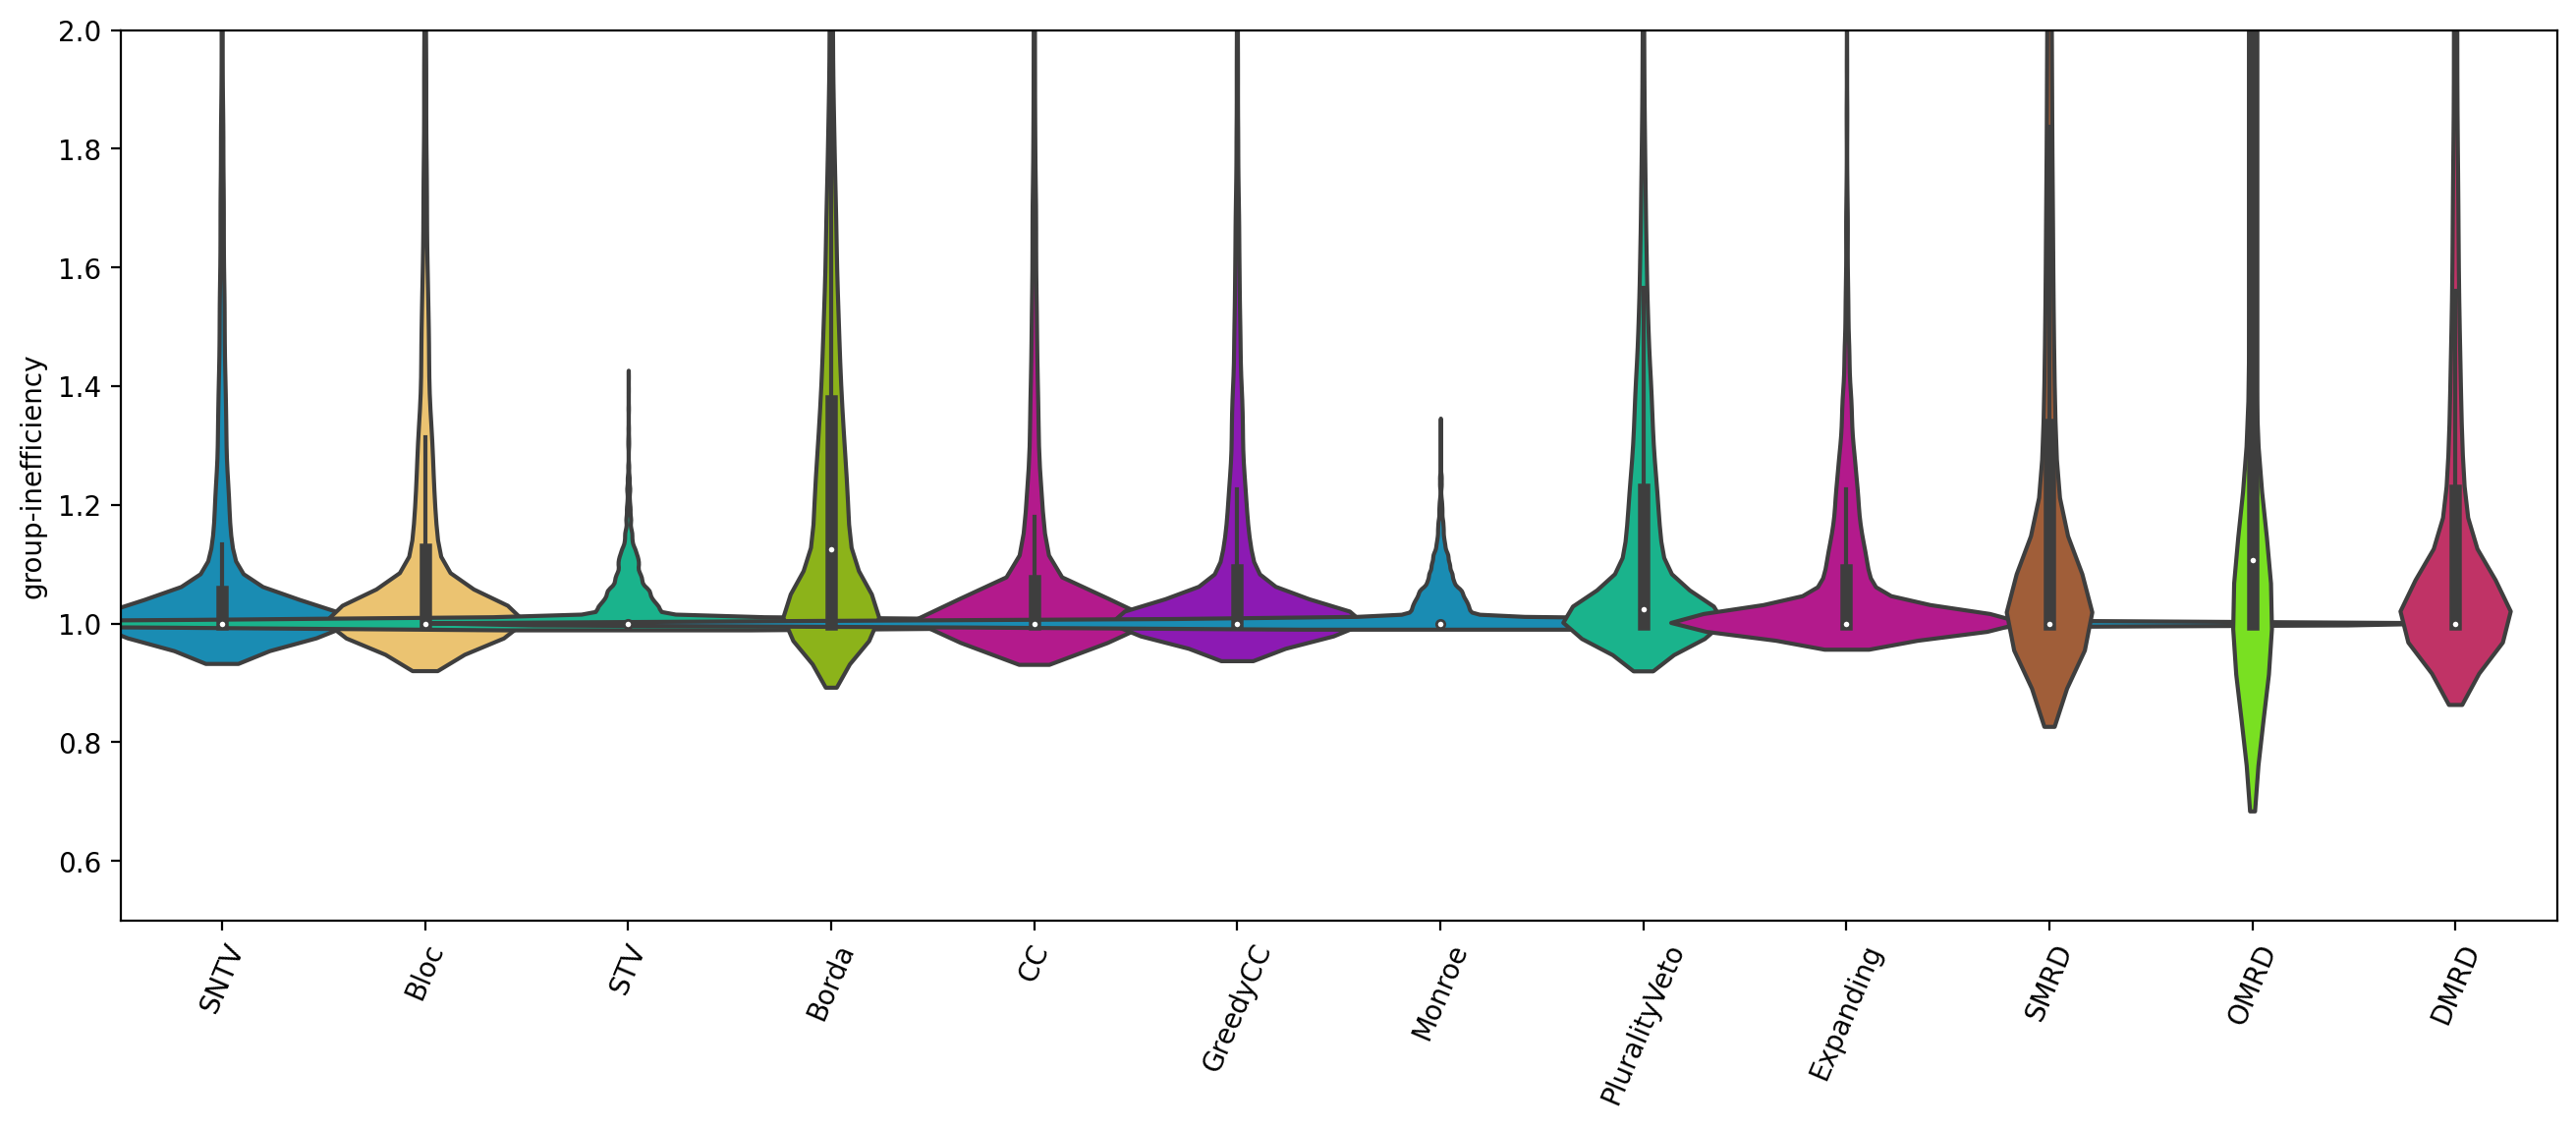

In [60]:
#########################################################################################################################
# Plot Group Inefficiency Analysis:
plt.figure(figsize=(16, 6), dpi = 200)

# BUG FIX for now:
represent_data = np.array(represent_data)
mask = np.all(represent_data >= 1, axis=0)
filtered_data = represent_data[:, mask]

ax = sns.violinplot(data=filtered_data.T, palette = colors2, alpha = 1, width = 10)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0.5, 2)
plt.xticks(ticks=np.arange(len(elections_list)), labels=represent_labels, rotation=67)
plt.ylabel('group-inefficiency')

#####################################################################################################################

Text(0, 0.5, 'overall-inefficiency')

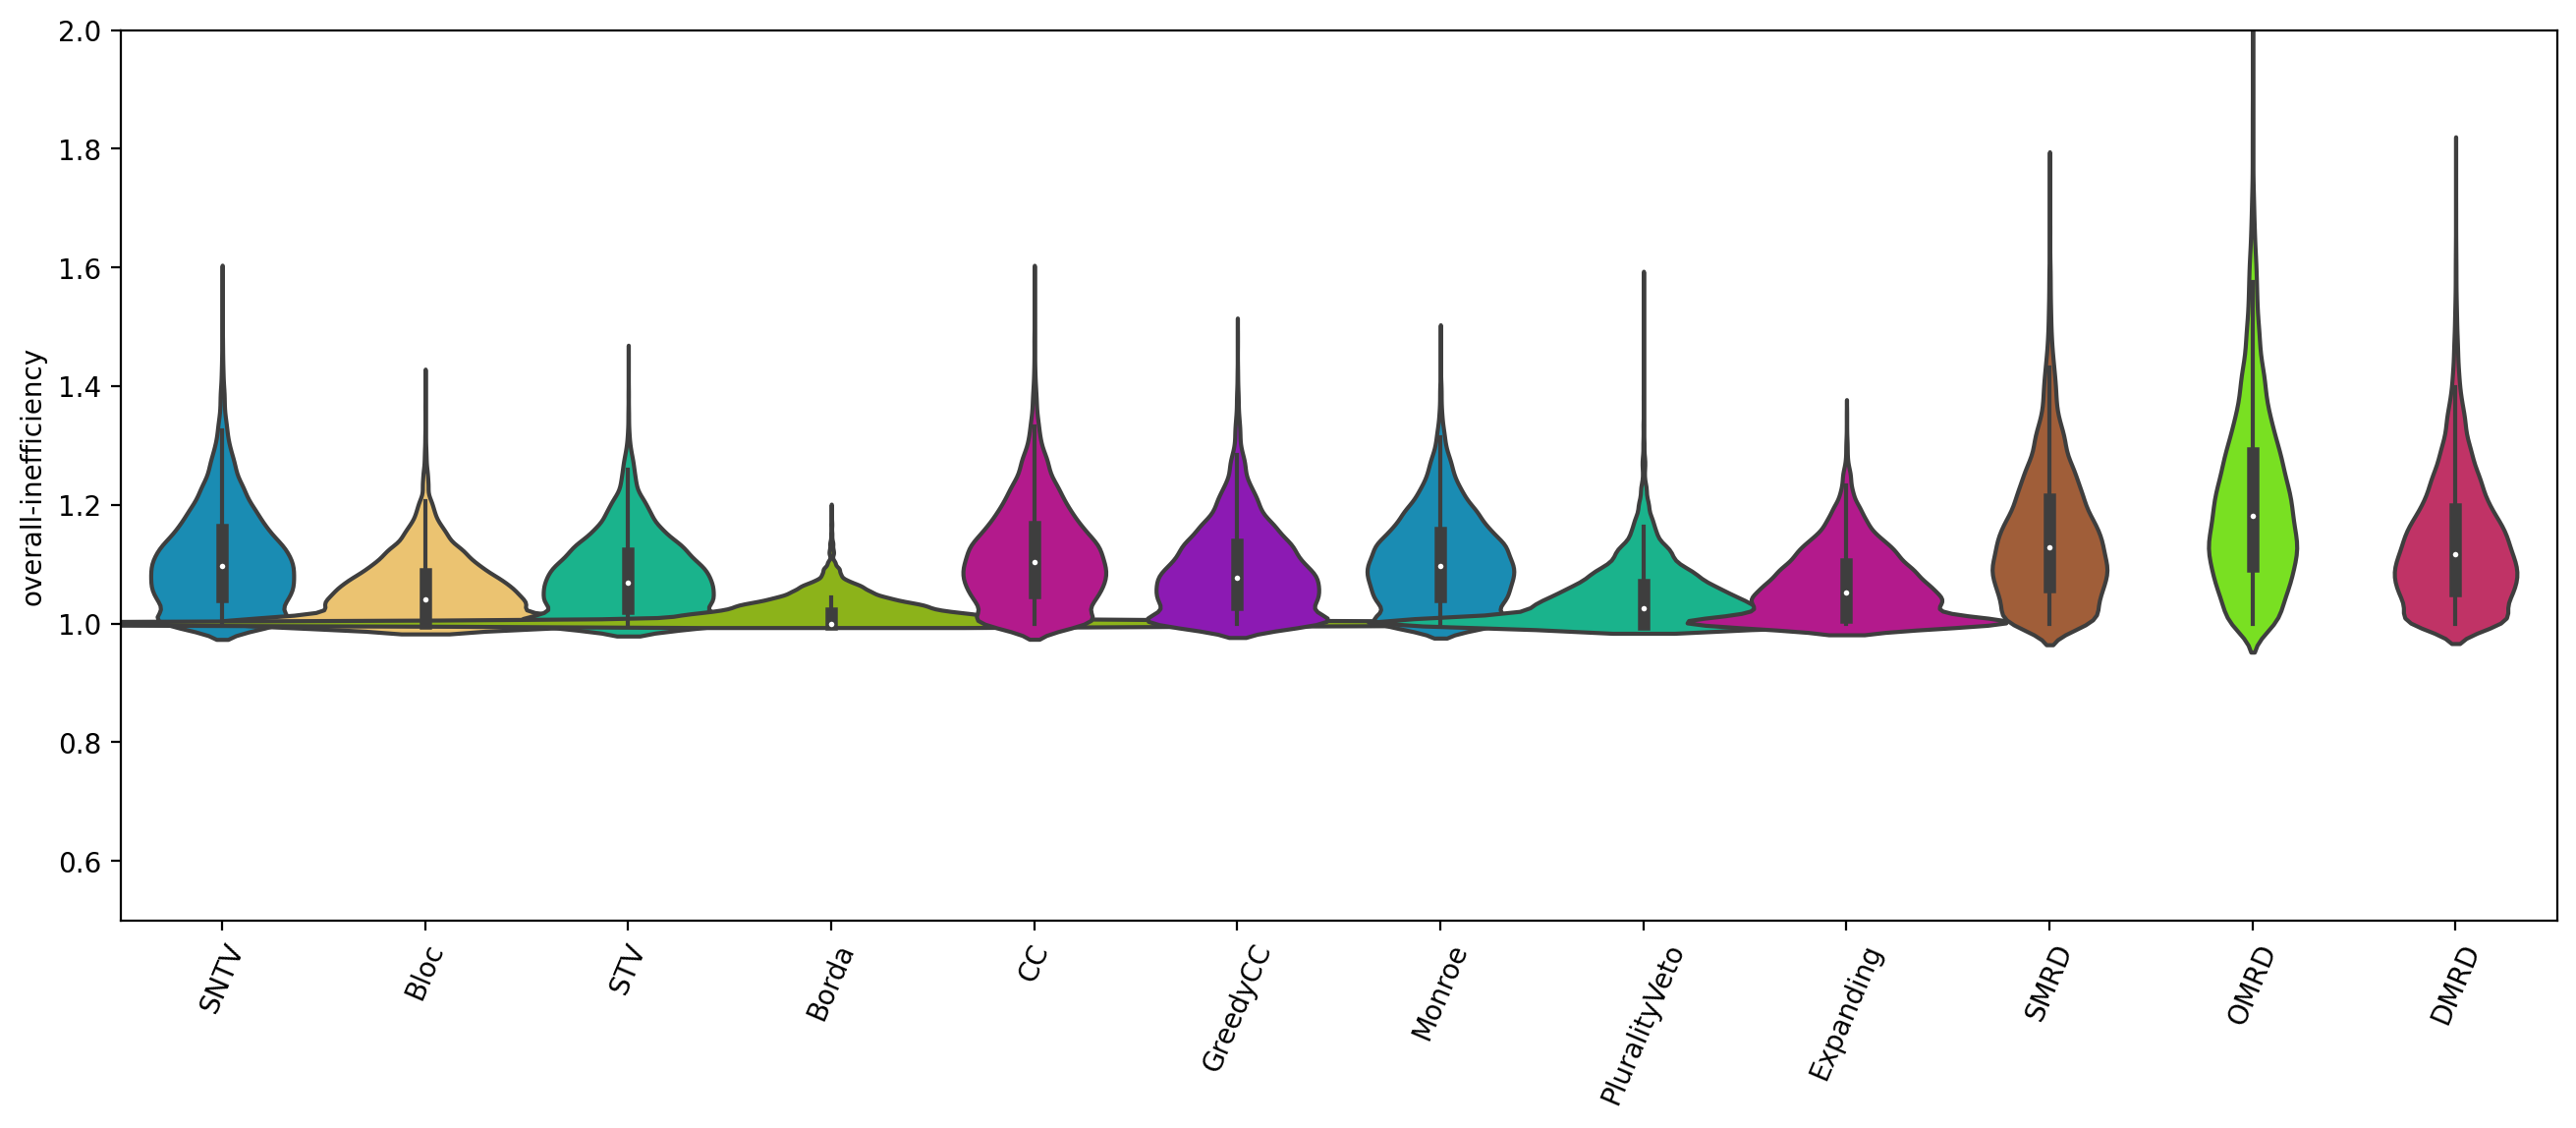

In [61]:
#####################################################################################################################
# Plot Overall Inefficiency Analysis:
plt.figure(figsize=(16, 6), dpi = 200)

# BUG FIX for now:
represent_data_overall = np.array(represent_data_overall)
mask = np.all(represent_data_overall >= 1, axis=0)
filtered_data_overall = represent_data_overall[:, mask]

ax = sns.violinplot(data=filtered_data_overall.T, palette = colors2, alpha = 1, width = 10)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0.5, 2)
plt.xticks(ticks=np.arange(len(elections_list)), labels=represent_labels_overall, rotation=67)
plt.ylabel('overall-inefficiency')

#################################################################################################33

Text(0, 0.5, 'worst-group-inefficiency')

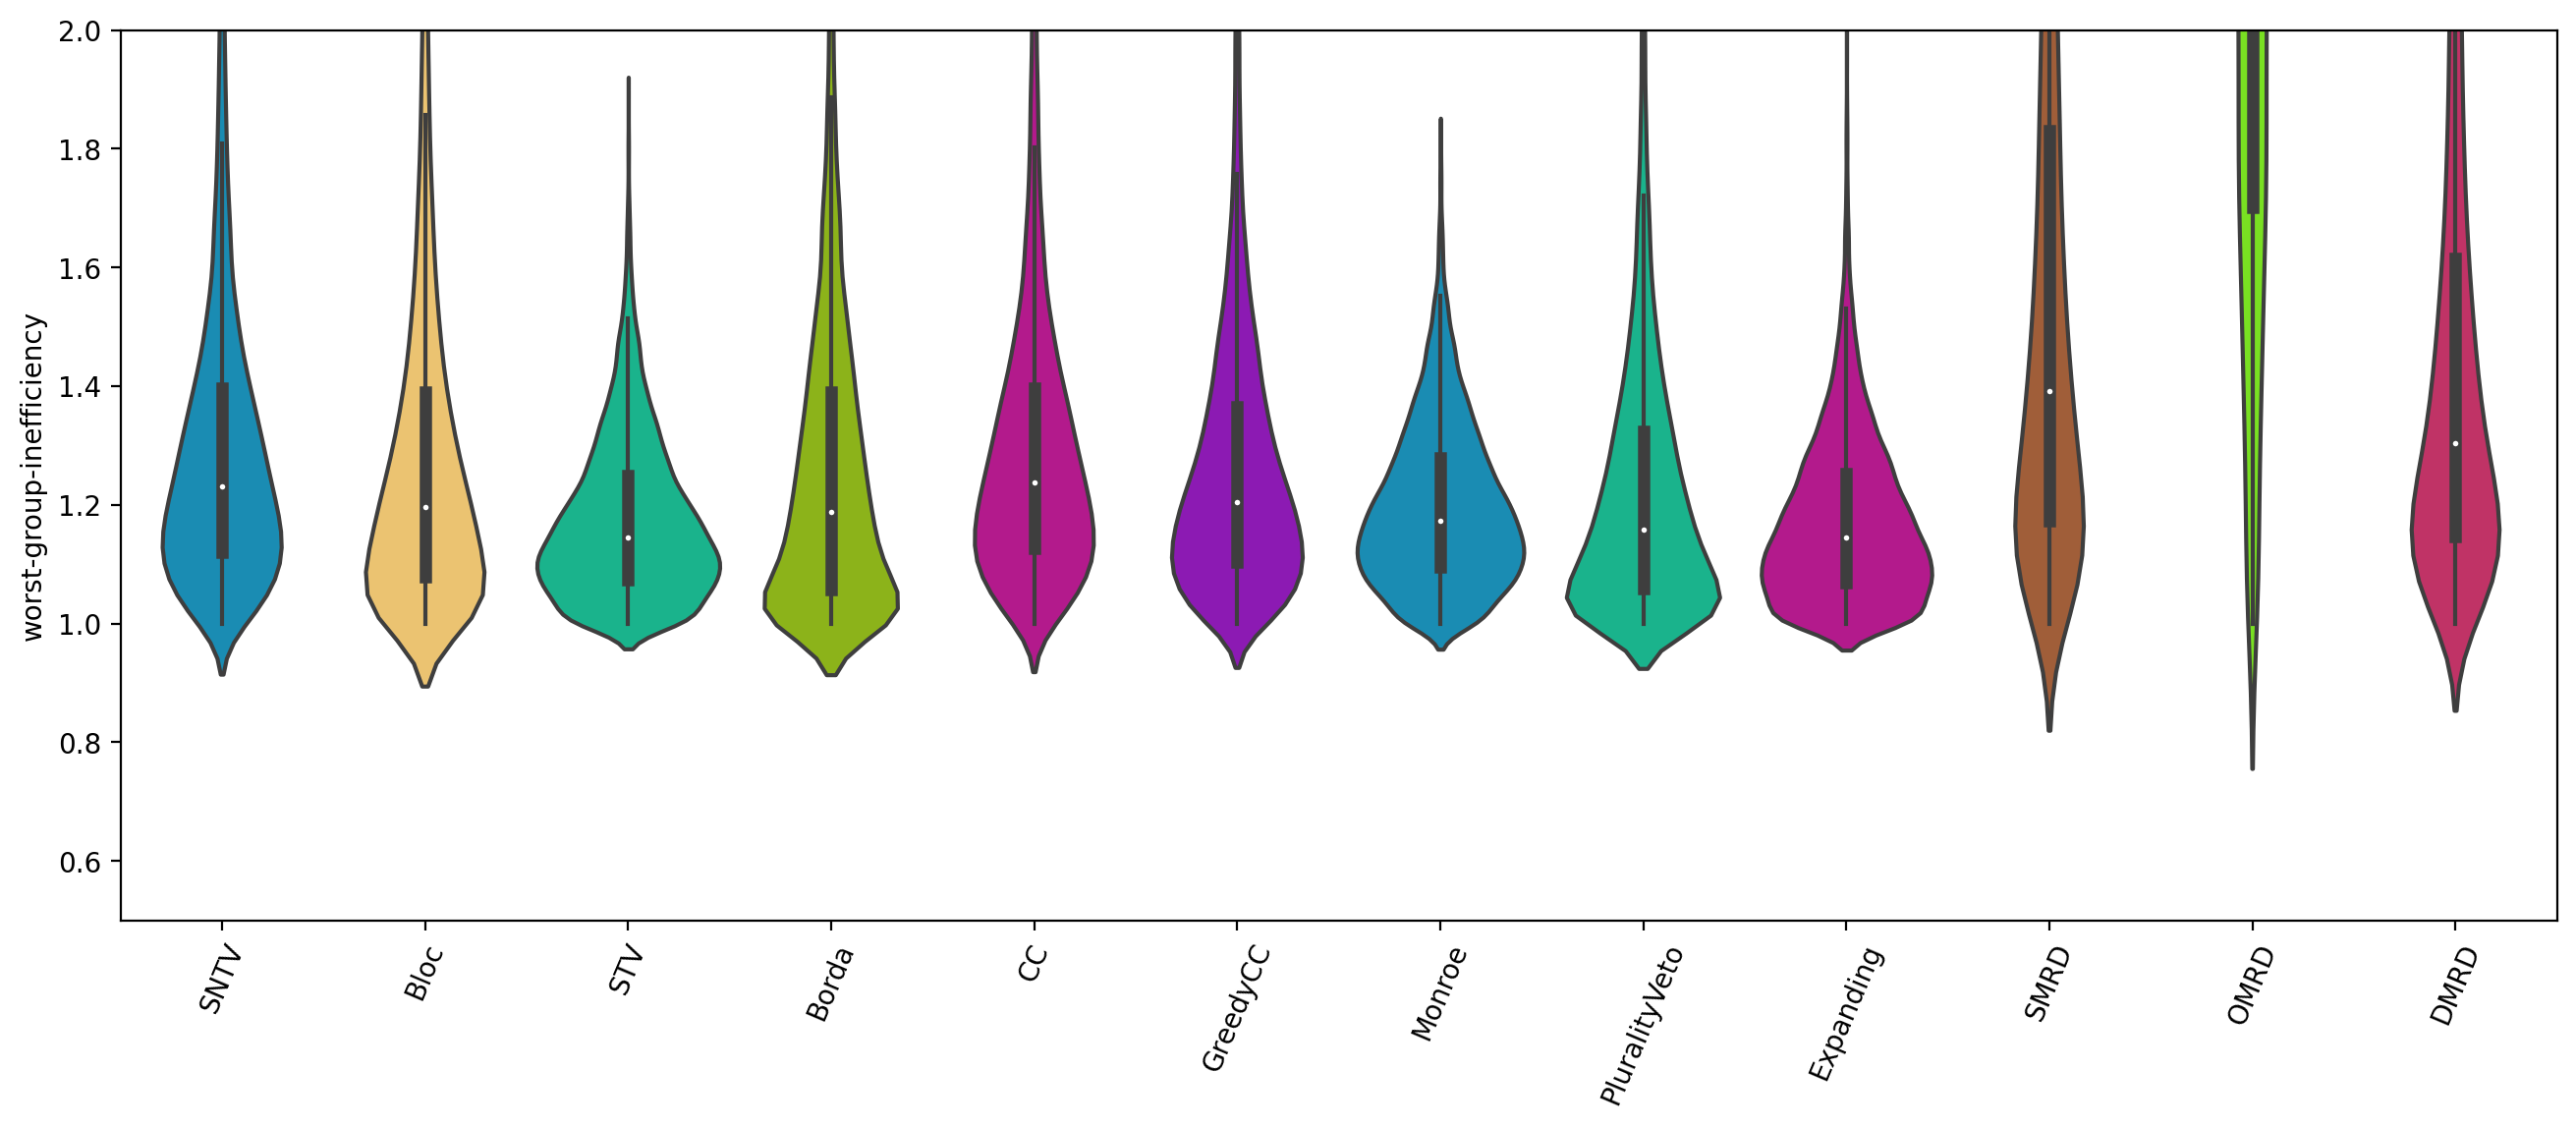

In [63]:
#####################################################################################################################
# Plot worst Inefficiency Analysis:
plt.figure(figsize=(16, 6), dpi = 200)

# BUG FIX for now:
represent_data_worst = np.array(represent_data_worst)
mask = np.all(represent_data_worst >= 1, axis=0)
filtered_data_worst = represent_data_worst[:, mask]

ax = sns.violinplot(data=filtered_data_worst.T, palette = colors2, alpha = 1, width = 0.9)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0.5, 2)
plt.xticks(ticks=np.arange(len(elections_list)), labels=represent_labels_worst, rotation=67)
plt.ylabel('worst-group-inefficiency')

#################################################################################################33

### Changing Group Sizes

We were also interested to see when group sizes became unbalanced. Keeping 100 total voters,
we altered the percenatage (from 0 to 100) of the total voters assigned to one of the groups.
The samples for this are precomputed, but the file `experiments/2sizes.py` has all the code needed 
to recompute the data yourself.

In [33]:
# For each size trial, we computed 1,000 samples
n_samples = 1000

In [38]:
group_sizes = [[100 - i, i] for i in range(0, 105, 5)]
group_select = 1
num_sizes = len(group_sizes)

size_avg_represent = {e.__name__:(np.zeros(num_sizes), np.zeros(num_sizes)) for e in elections_list}
size_avg_represent_overall = {e.__name__:(np.zeros(num_sizes), np.zeros(num_sizes)) for e in elections_list}

for s in range(num_sizes):
    f = 'data/2sizes' + str(s) + '.npz'
    loaded_data = np.load(f)
    result_dict = {key: loaded_data[key] for key in loaded_data.files}
    
    s_avg_represent = {e.__name__:np.zeros(n_samples) for e in elections_list}
    s_avg_represent_overall = {e.__name__:np.zeros(n_samples) for e in elections_list}
    
    for i in range(n_samples):
        voter_positions = result_dict['voters'][i]
        candidate_positions = result_dict['candidates'][i]
        labels = result_dict['labels'][i]
        labels_overall = np.zeros(len(labels))

        for j,E in enumerate(elections_list):
            name = E.__name__
                
            winners = result_dict[name][i]
            represent = group_representation(voter_positions, candidate_positions, labels, winners, group_select, size = None)
            represent_overall = group_representation(voter_positions, candidate_positions, labels_overall, winners, 0, size = None)
            s_avg_represent[name][i] = represent
            s_avg_represent_overall[name][i] = represent_overall
            
    for ename, evals in s_avg_represent.items():
        # BUG fix for now:
        eval_data = evals[evals >= 1]
        size_avg_represent[ename][0][s] = np.mean(eval_data)
        size_avg_represent[ename][1][s] = np.std(eval_data)
        
    for ename, evals in s_avg_represent_overall.items():
        # BUG fix for now:
        eval_data = evals[evals >= 1]
        size_avg_represent_overall[ename][0][s] = np.mean(eval_data)
        size_avg_represent_overall[ename][1][s] = np.std(eval_data)

C:\Users\kq146\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kq146\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\kq146\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\kq146\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\kq146\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


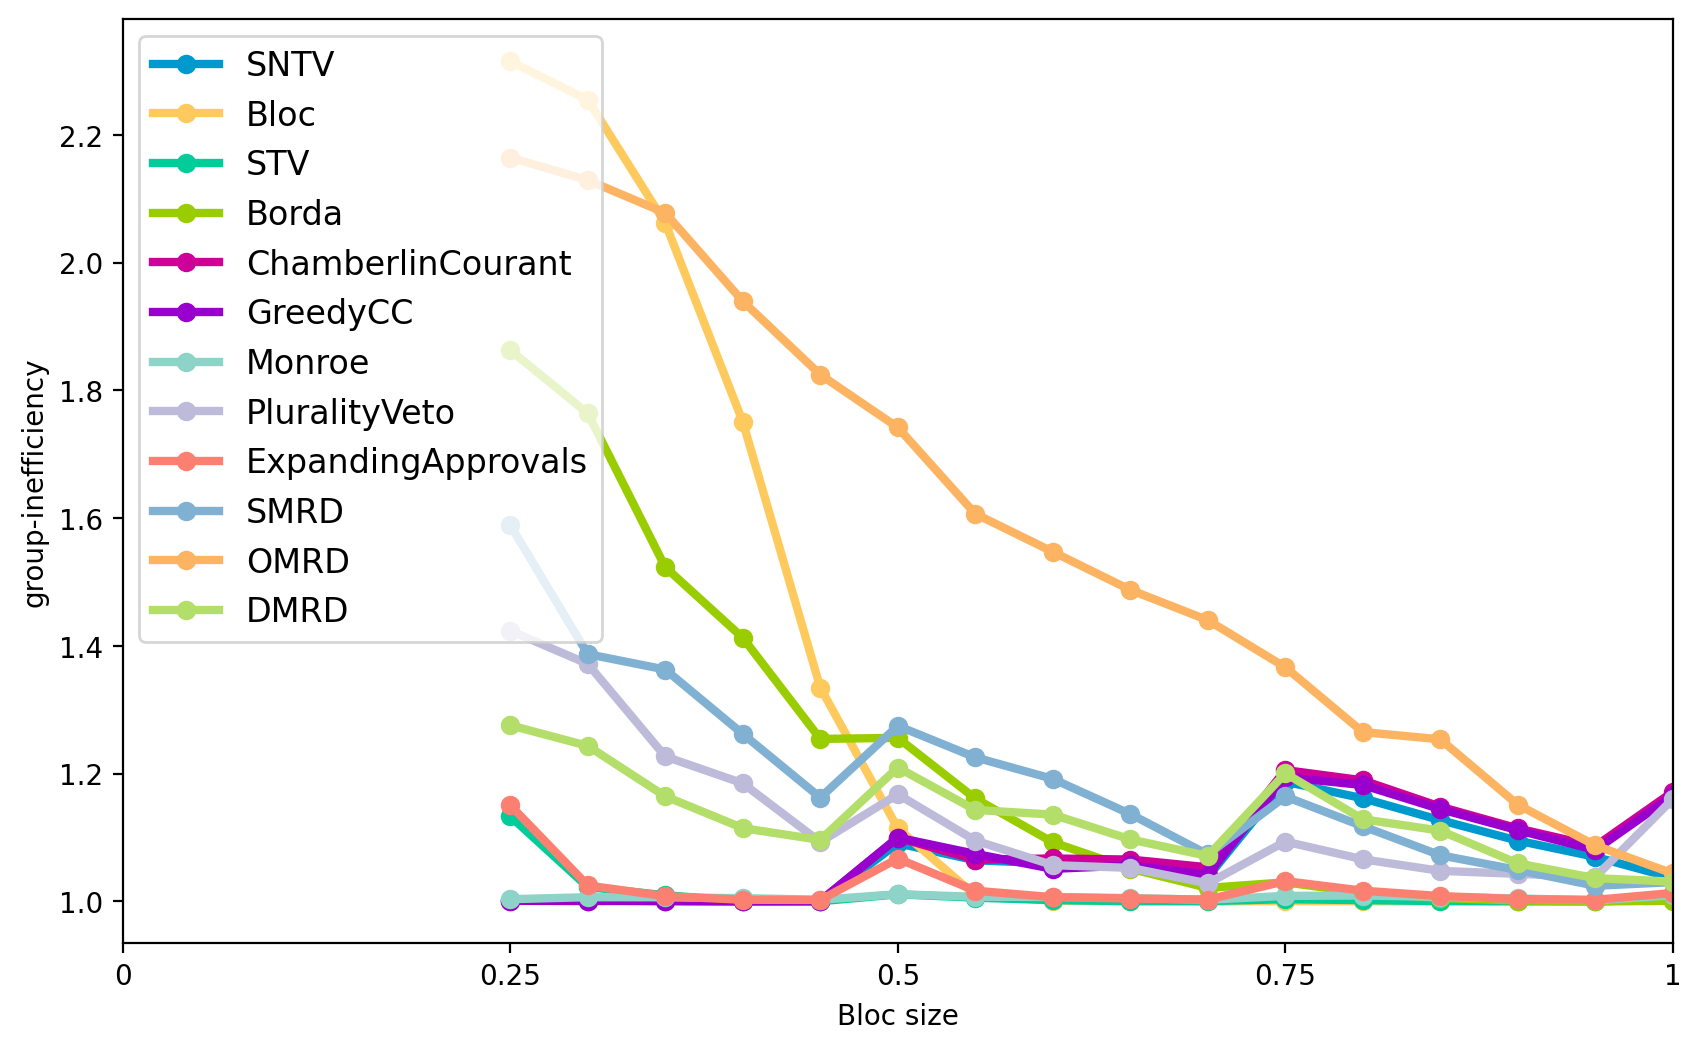

In [39]:
###############################################################################################
# 1) Plot group in-efficiency analysis.
fig,ax = plt.subplots(figsize=(10, 6), dpi = 200)

Asizes = [x[group_select]/100 for x in group_sizes]
for i, (ename,evals) in enumerate(size_avg_represent.items()):
    if name == 'ChamberlinCourant':
        name_label = 'CC'
    elif name == 'ExpandingApprovals':
        name_label = 'Expanding'
    ax.plot(Asizes[5:], evals[0][5:], label=ename, color = colors[i], linewidth = 3, marker = 'o')
    #ax.fill_between(Asizes, evals[0] - evals[1], evals[0] + evals[1], color=tab20_colors[i], alpha=0.05)
    

ax.set_xlim(0, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])
ax.set_ylabel('group-inefficiency')
ax.set_xlabel('Bloc size')
plt.legend(fontsize = 12, loc = 'upper left')
plt.show()

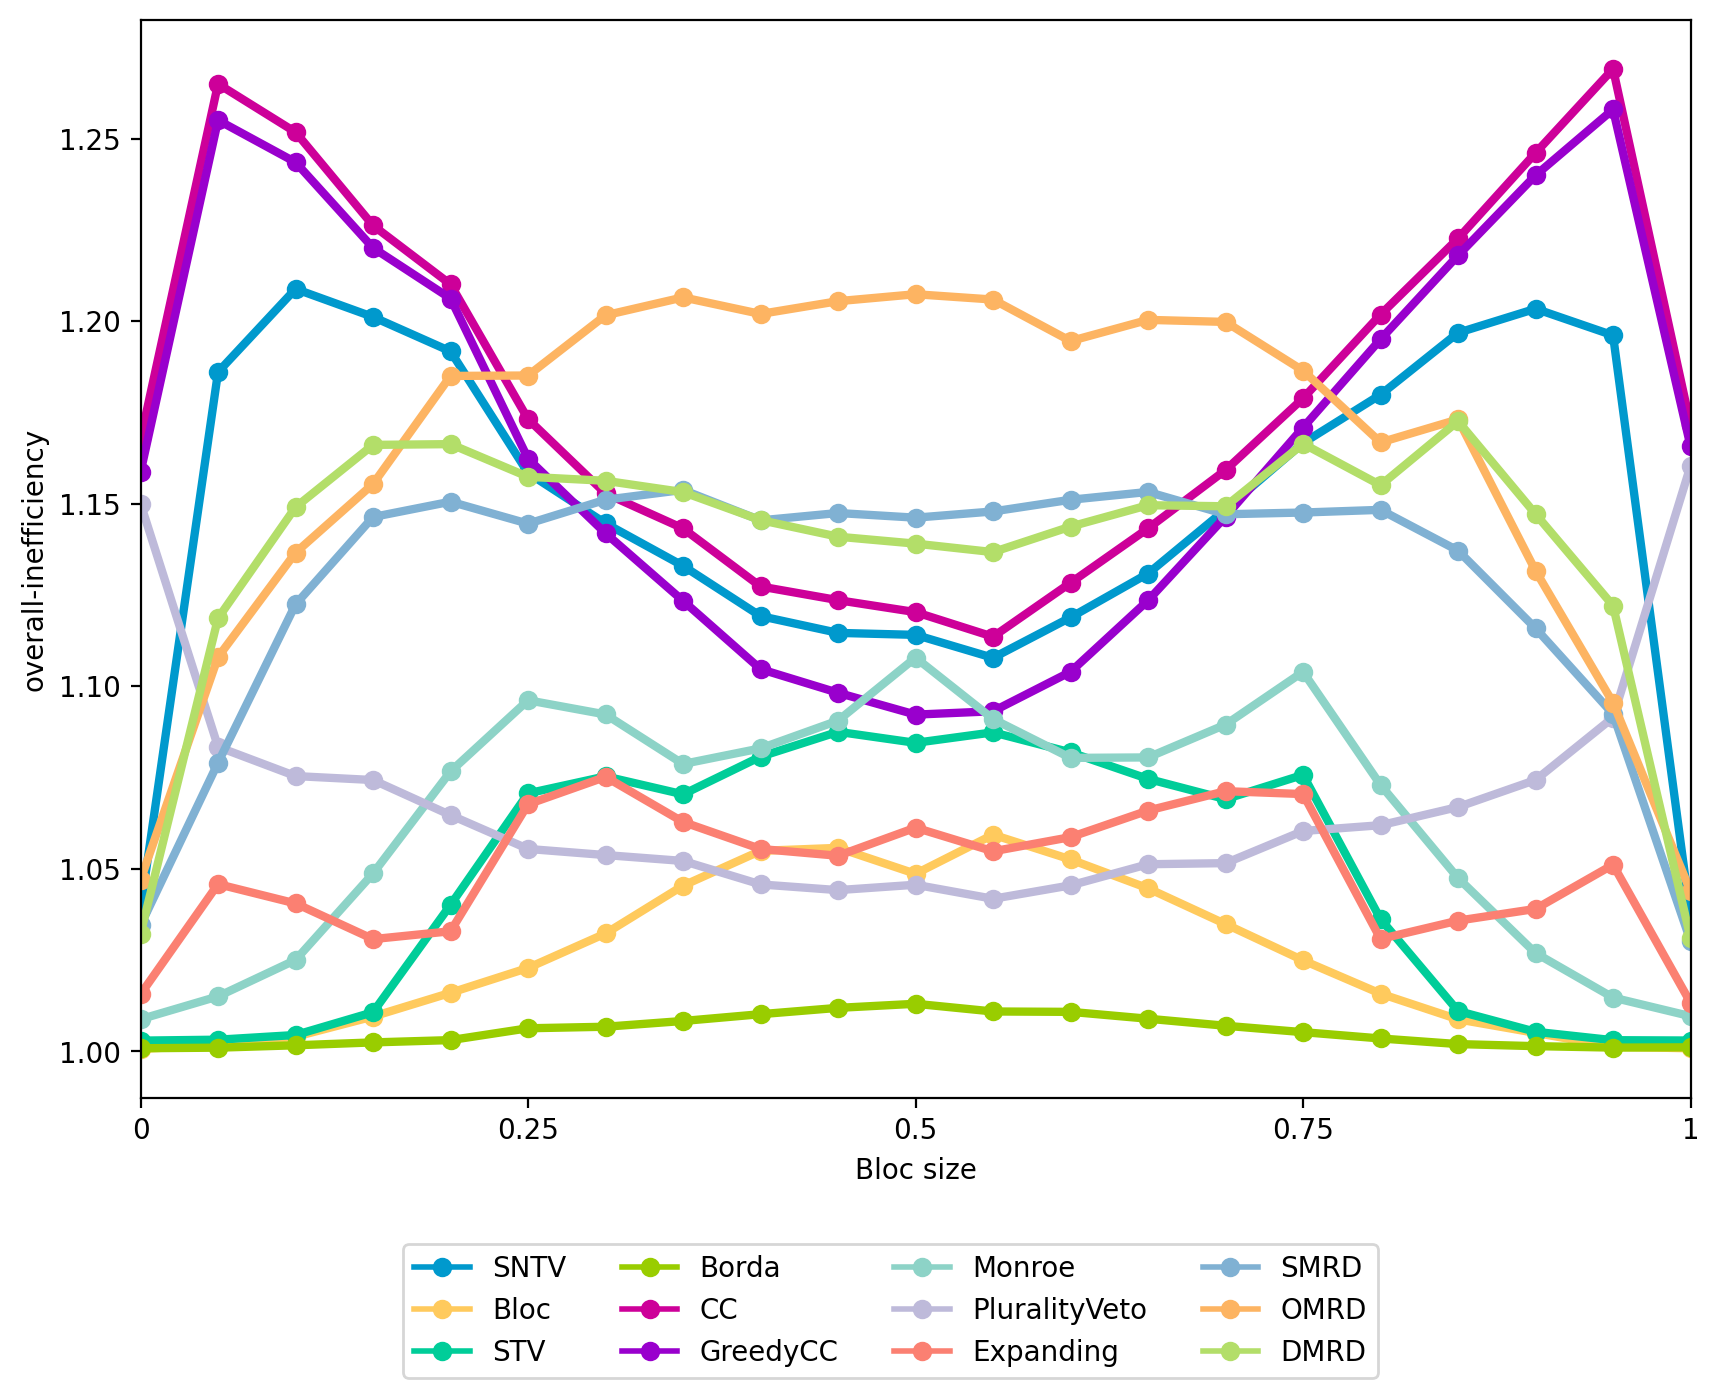

In [41]:
###############################################################################################################
# 2) Plot overall in-efficiency analysis.
fig,ax = plt.subplots(figsize=(10, 7), dpi = 200)

Asizes = [x[group_select]/100 for x in group_sizes]
for i, (ename,evals) in enumerate(size_avg_represent_overall.items()):
    if name == 'ChamberlinCourant':
        name_label = 'CC'
    elif name == 'ExpandingApprovals':
        name_label = 'Expanding'
    ax.plot(Asizes, evals[0], label=ename, color = colors[i], linewidth = 3, marker = 'o')
    #ax.fill_between(Asizes, evals[0] - evals[1], evals[0] + evals[1], color=tab20_colors[i], alpha=0.05)

plt.ylabel('overall-inefficiency')
plt.xlabel('Bloc size')

names = [ename for ename in size_avg_represent_overall.keys()]
names = ['CC' if n == 'ChamberlinCourant' else n for n in names]
names = ['Expanding' if n == 'ExpandingApprovals' else n for n in names]
legend_elements = [Line2D([0], [0], marker = 'o', color=colors[i], lw=2, label=names[i]) for i in range(len(names))]


ax.set_xlim(0, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()